# Cifar10

In [1]:
import tensorflow as tf
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

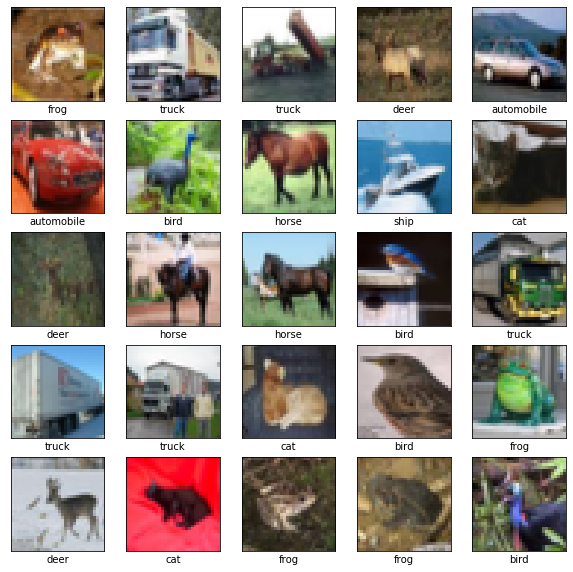

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [4]:
train_images.shape[0]

50000

# 1. cifar10 dataset으로 model 학습(baseline model)

In [5]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10)
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [8]:
h_model = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 193us/sample - loss: 1.5352 - accuracy: 0.4379 - val_loss: 1.2445 - val_accuracy: 0.5632
Epoch 2/10
50000/50000 [==============================] - 8s 158us/sample - loss: 1.1726 - accuracy: 0.5834 - val_loss: 1.0699 - val_accuracy: 0.6189
Epoch 3/10
50000/50000 [==============================] - 7s 144us/sample - loss: 1.0114 - accuracy: 0.6447 - val_loss: 1.0529 - val_accuracy: 0.6270
Epoch 4/10
50000/50000 [==============================] - 7s 138us/sample - loss: 0.9164 - accuracy: 0.6764 - val_loss: 0.9321 - val_accuracy: 0.6721
Epoch 5/10
50000/50000 [==============================] - 7s 135us/sample - loss: 0.8412 - accuracy: 0.7050 - val_loss: 0.9049 - val_accuracy: 0.6861
Epoch 6/10
50000/50000 [==============================] - 7s 138us/sample - loss: 0.7857 - accuracy: 0.7229 - val_loss: 0.8948 - val_accuracy: 0.6889
Epoch 7/10
50000/50000 [=========================

In [9]:
baseline_model_loss, baseline_model_accuracy = model.evaluate(test_images,  test_labels, verbose=2)

10000/1 - 1s - loss: 1.1175 - accuracy: 0.7033


In [10]:
predictions = model.predict(test_images)

In [11]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmpfr00fi1t.h5


# 2. baseline model with only pruning

In [12]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 4 epochs.
batch_size = 128
epochs = 10
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()


Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 30, 30, 32)        1762      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 15, 15, 32)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 13, 13, 64)        36930     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 6, 6, 64)          1         
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 4, 4, 64)          73794     
_________________________________________________________________
prune_low_magnitude_flatten  (None, 1024)              1         
_________________________________________________

In [13]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
h_pruned_model = model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 7s 154us/sample - loss: 0.5702 - accuracy: 0.8004 - val_loss: 0.5222 - val_accuracy: 0.8184
Epoch 2/10
45000/45000 [==============================] - 5s 110us/sample - loss: 0.5444 - accuracy: 0.8095 - val_loss: 0.6457 - val_accuracy: 0.7716
Epoch 3/10
45000/45000 [==============================] - 5s 104us/sample - loss: 0.5545 - accuracy: 0.8036 - val_loss: 0.5721 - val_accuracy: 0.8004
Epoch 4/10
45000/45000 [==============================] - 5s 108us/sample - loss: 0.5828 - accuracy: 0.7952 - val_loss: 0.7319 - val_accuracy: 0.7498
Epoch 5/10
45000/45000 [==============================] - 5s 102us/sample - loss: 0.5569 - accuracy: 0.8046 - val_loss: 0.6425 - val_accuracy: 0.7706
Epoch 6/10
45000/45000 [==============================] - 5s 100us/sample - loss: 0.5857 - accuracy: 0.7981 - val_loss: 1.0448 - val_accuracy: 0.6430
Epoch 7/10
45000/45000 [===========================

##### accuracy : baseline, pruned model

In [14]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline test accuracy: 0.7033
Pruned test accuracy: 0.7225


In [15]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpoqpsxyy2.h5


# 3-1. baseline model with only quantizing

In [16]:
quantize_model = tfmot.quantization.keras.quantize_model

In [17]:
q_aware_model = quantize_model(model)

In [18]:
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
q_aware_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantizeWrappe (None, 30, 30, 32)        963       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 15, 15, 32)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 13, 13, 64)        18627     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 6, 6, 64)          1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 4, 4, 64)          37059     
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 1024)              1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 64)                6

In [20]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

h_quantized_model = q_aware_model.fit(train_images_subset, train_labels_subset,
                                      batch_size=500, epochs=6, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/6
900/900 [==============================] - 1s 974us/sample - loss: 0.4828 - accuracy: 0.8356 - val_loss: 0.7807 - val_accuracy: 0.7300
Epoch 2/6
900/900 [==============================] - 0s 88us/sample - loss: 0.6896 - accuracy: 0.7733 - val_loss: 0.5126 - val_accuracy: 0.7900
Epoch 3/6
900/900 [==============================] - 0s 100us/sample - loss: 0.4655 - accuracy: 0.8433 - val_loss: 0.5360 - val_accuracy: 0.7900
Epoch 4/6
900/900 [==============================] - 0s 95us/sample - loss: 0.4177 - accuracy: 0.8689 - val_loss: 0.4766 - val_accuracy: 0.8700
Epoch 5/6
900/900 [==============================] - 0s 79us/sample - loss: 0.3781 - accuracy: 0.8822 - val_loss: 0.4686 - val_accuracy: 0.8700
Epoch 6/6
900/900 [==============================] - 0s 89us/sample - loss: 0.3546 - accuracy: 0.8878 - val_loss: 0.5038 - val_accuracy: 0.8400


##### accuracy : baseline,  pruned model,  quantized model

In [21]:
_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)


Baseline test accuracy: 0.7033
Pruned test accuracy: 0.7225
Quant test accuracy: 0.6934


In [22]:
_, quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_model, quantized_keras_file, include_optimizer=False)
print('Saved quantized Keras model to:', quantized_keras_file)


Saved quantized Keras model to: /tmp/tmpcai61x36.h5


# 3-2. baseline model with post-quatizing

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quan_tflite_model = converter.convert()

_,post_quan_tflite_file = tempfile.mkstemp('.tflite')

In [24]:
print('Saved post-quantized TFLite model to:',post_quan_tflite_file)

Saved post-quantized TFLite model to: /tmp/tmpgmx4ldw_.tflite


In [25]:
# tflite 정확도 측정 함수
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels).mean()
  return accuracy


In [26]:
interpreter_post_q = tf.lite.Interpreter(model_content=post_quan_tflite_model)
interpreter_post_q.allocate_tensors()

test_post_q_accuracy = evaluate_model(interpreter_post_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




##### accuracy : baseline,  pruned model,  quantized model,  post-quantized model

In [27]:
print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)
print('Post-Quant test accuracy:', test_post_q_accuracy)


Baseline test accuracy: 0.7033
Pruned test accuracy: 0.7225
Quant test accuracy: 0.6934
Post-Quant test accuracy: 0.1


# 4.pruned model and quantized model convert to TFLite

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmptasgz8wk.tflite


In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
quantized_tflite_model = converter.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_tflite_file, 'wb') as f:
    f.write(quantized_tflite_model)

print('Saved quantized TFLite model to:', quantized_tflite_file)

Saved quantized TFLite model to: /tmp/tmprvcyybnz.tflite


In [30]:
interpreter_p = tf.lite.Interpreter(model_content=pruned_tflite_model)
interpreter_q = tf.lite.Interpreter(model_content=quantized_tflite_model)

interpreter_p.allocate_tensors()
interpreter_q.allocate_tensors()

test_accuracy_p = evaluate_model(interpreter_p)
test_accuracy_q = evaluate_model(interpreter_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [31]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")

Baseline test accuracy: 0.7033 

Pruned test accuracy: 0.7225 

Quant test accuracy: 0.6934 

Post-Quant test accuracy: 0.1 

Prun TFLite test_accuracy: 0.1 

Quant TFLite test_accuracy: 0.1 



# 5-1. baseline model with pruning and quantizing

In [32]:
q_aware_prun_model = quantize_model(model_for_export)

In [33]:
q_aware_prun_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
q_aware_prun_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantizeWrappe (None, 30, 30, 32)        963       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 15, 15, 32)        1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 13, 13, 64)        18627     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 6, 6, 64)          1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 4, 4, 64)          37059     
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 1024)              1         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 64)                6

In [35]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

h_quan_prun_model = q_aware_prun_model.fit(train_images_subset, train_labels_subset,
                  batch_size=128, epochs=4, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/4
900/900 [==============================] - 1s 973us/sample - loss: 0.6140 - accuracy: 0.7878 - val_loss: 0.6535 - val_accuracy: 0.7400
Epoch 2/4
900/900 [==============================] - 0s 156us/sample - loss: 0.4673 - accuracy: 0.8356 - val_loss: 0.5520 - val_accuracy: 0.7900
Epoch 3/4
900/900 [==============================] - 0s 201us/sample - loss: 0.3678 - accuracy: 0.8822 - val_loss: 0.4856 - val_accuracy: 0.8700
Epoch 4/4
900/900 [==============================] - 0s 142us/sample - loss: 0.3016 - accuracy: 0.9067 - val_loss: 0.4818 - val_accuracy: 0.8300


In [36]:
_, q_aware_prun_model_accuracy =q_aware_prun_model.evaluate(test_images, test_labels, verbose=0)

In [37]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")

Baseline test accuracy: 0.7033 

Pruned test accuracy: 0.7225 

Quant test accuracy: 0.6934 

Post-Quant test accuracy: 0.1 

Prun TFLite test_accuracy: 0.1 

Quant TFLite test_accuracy: 0.1 

Pruned and quantized test_accuracy: 0.6965 



In [38]:
_, pruned_and_quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_prun_model, pruned_and_quantized_keras_file, include_optimizer=False)
print('Saved pruned and quantized Keras model to:', pruned_and_quantized_keras_file)

Saved pruned and quantized Keras model to: /tmp/tmp7uy_g9y5.h5


# 5-2. baseline model with pruning and post-quantizing

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quantized_and_pruned_tflite_model = converter.convert()

_, post_quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(post_quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(post_quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', post_quantized_and_pruned_tflite_file)

Saved quantized and pruned TFLite model to: /tmp/tmpqdv4638u.tflite


In [40]:
interpreter_p_post_q = tf.lite.Interpreter(model_content=post_quantized_and_pruned_tflite_model)
interpreter_p_post_q.allocate_tensors()

test_accuracy_p_post_q = evaluate_model(interpreter_p_post_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [41]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")

Baseline test accuracy: 0.7033 

Pruned test accuracy: 0.7225 

Quant test accuracy: 0.6934 

Post-Quant test accuracy: 0.1 

Prun TFLite test_accuracy: 0.1 

Quant TFLite test_accuracy: 0.1 

Pruned and quantized test_accuracy: 0.6965 

Pruned and post-quantized test_accuracy: 0.1 



# 6.  pruned and quantized model convert to TFLite

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_prun_model)
pruned_quantized_tflite_model = converter.convert()

_, pruned_quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_quantized_tflite_file, 'wb') as f:
    f.write(pruned_quantized_tflite_model)

print('Saved pruned TFLite model to:', pruned_quantized_tflite_file)

Saved pruned TFLite model to: /tmp/tmpg1qzlt3c.tflite


In [43]:
interpreter_p_q = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter_p_q.allocate_tensors()

test_accuracy_p_q = evaluate_model(interpreter_p_q)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.




In [44]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and quantized TFLite test_accuracy:', test_accuracy_p_q,"\n")

Baseline test accuracy: 0.7033 

Pruned test accuracy: 0.7225 

Quant test accuracy: 0.6934 

Post-Quant test accuracy: 0.1 

Prun TFLite test_accuracy: 0.1 

Quant TFLite test_accuracy: 0.1 

Pruned and quantized test_accuracy: 0.6965 

Pruned and post-quantized test_accuracy: 0.1 

Pruned and quantized TFLite test_accuracy: 0.1 



# 결론(Result)

### 모든 모델의 정확도

In [45]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_q,"\n")

Baseline test accuracy: 0.7033 

Pruned test accuracy: 0.7225 

Quant test accuracy: 0.6934 

Post-Quant test accuracy: 0.1 

Prun TFLite test_accuracy: 0.1 

Quant TFLite test_accuracy: 0.1 

Pruned and quantized test_accuracy: 0.6965 

Pruned and post-quantized test_accuracy: 0.1 

Pruned and post-quantized test_accuracy: 0.1 



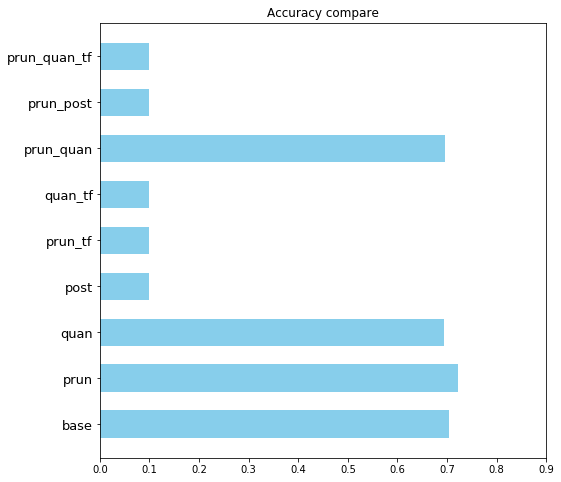

In [46]:
from matplotlib import pyplot as plt

y = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()


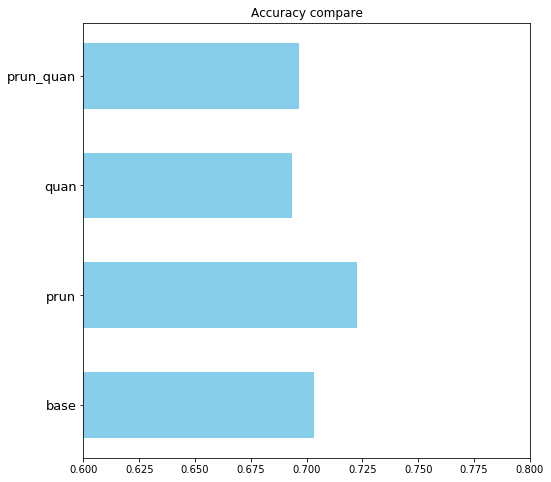

In [48]:
y = [baseline_model_accuracy,
     model_for_pruning_accuracy,
     q_aware_model_accuracy,
     q_aware_prun_model_accuracy]

x = ["base", "prun", "quan","prun_quan"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
plt.xlim(0.6,0.8)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

### 모든 모델의 크기

In [49]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


In [50]:
print("Size of gzipped baseline Keras model: %.2f bytes\n" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped quantizied Keras model: %.2f bytes\n" % (get_gzipped_model_size(quantized_keras_file)))
print("Size of gzipped post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quan_tflite_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_tflite_file)))
print("Size of gzipped quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(quantized_tflite_file)))
print("Size of gzipped pruned and quantized Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_and_quantized_keras_file)))
print("Size of gzipped pruned and post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quantized_and_pruned_tflite_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_quantized_tflite_file)))

Size of gzipped baseline Keras model: 459602.00 bytes

Size of gzipped pruned Keras model: 148966.00 bytes

Size of gzipped quantizied Keras model: 318807.00 bytes

Size of gzipped post-quantized model: 144.00 bytes

Size of gzipped pruned TFlite model: 145266.00 bytes

Size of gzipped quantized TFlite model: 99247.00 bytes

Size of gzipped pruned and quantized Keras model: 319573.00 bytes

Size of gzipped pruned and post-quantized model: 42676.00 bytes

Size of gzipped pruned and quantized TFlite model: 108526.00 bytes



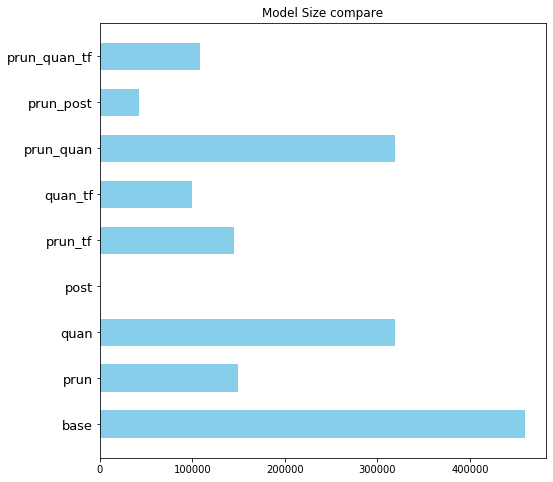

In [51]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]


x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

### accuracy and model size

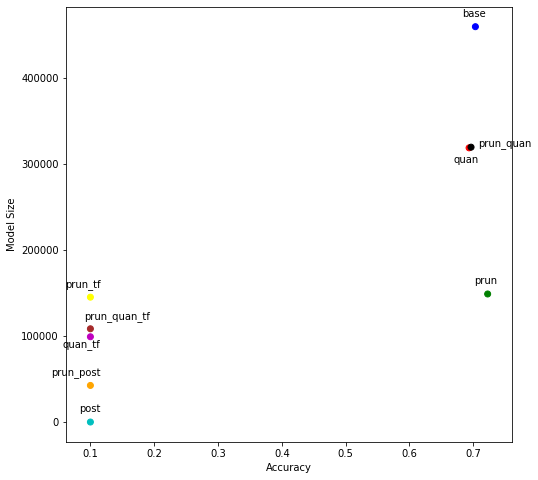

In [68]:
x = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

z = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]

c = ['b','g','r','c','yellow','m','k','orange',"brown"]
d = [(10,10),(10,10),(10,-15),(10,10),(10,10),(10,-10),(60,0),(10,10),(60,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

i = 0
for xs,ys in zip(x,y):
    plt.annotate(z[i], (xs,ys), textcoords="offset points",xytext=d[i],ha='right')
    i += 1
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()


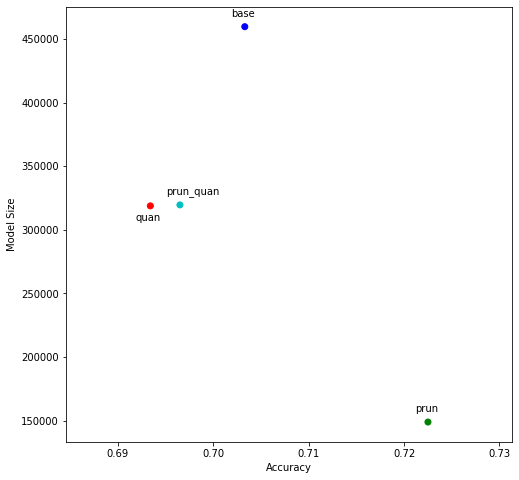

In [72]:
x = [baseline_model_accuracy,
     model_for_pruning_accuracy,
     q_aware_model_accuracy,
     q_aware_prun_model_accuracy]

y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file)]

z = ["base", "prun", "quan","prun_quan",]

c = ['b','g','r','c']
d = [(10,10),(10,10),(10,-15),(40,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

i = 0
for xs,ys in zip(x,y):
    plt.annotate(z[i], (xs,ys), textcoords="offset points",xytext=d[i],ha='right')
    i += 1
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()
